In [42]:
### Library Imports
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")


In [40]:
### Load in Stock Data
def import_stock_data(tickers, start_date):
    data = pd.DataFrame()
    if isinstance(tickers, str):
        tickers = [tickers]
        
    for ticker in tickers:
        data[ticker] = yf.download(ticker, start=start_date)['Adj Close']
        
    # Reset index to make headings in the same row
    data.reset_index(inplace=True)
    # Convert values in date col to dt
    data['Date'] = pd.to_datetime(data['Date'])

    return data

# Function Call
forex_pairs = ['EURUSD=X', 'GBPUSD=X', 'JPYUSD=X', 'AUDUSD=X']
start_date = '2022-01-01'
forex_data = import_stock_data(forex_pairs, start_date)
forex_data.tail()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,EURUSD=X,GBPUSD=X,JPYUSD=X,AUDUSD=X
635,2024-06-10,1.077888,1.272945,0.006376,0.658271
636,2024-06-11,1.076426,1.272637,0.006368,0.660895
637,2024-06-12,1.074033,1.274048,0.006365,0.660770
638,2024-06-13,1.081315,1.279623,0.006378,0.666290
639,2024-06-14,1.070320,1.268891,0.006356,0.661927


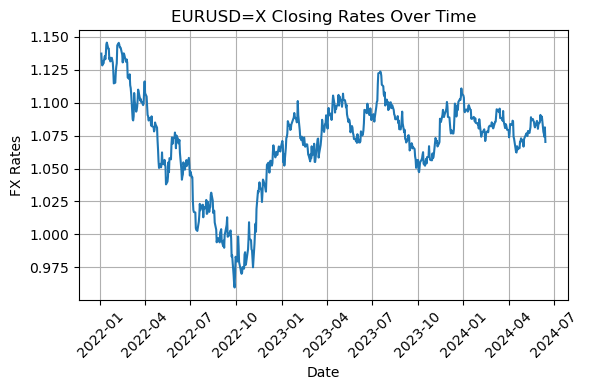

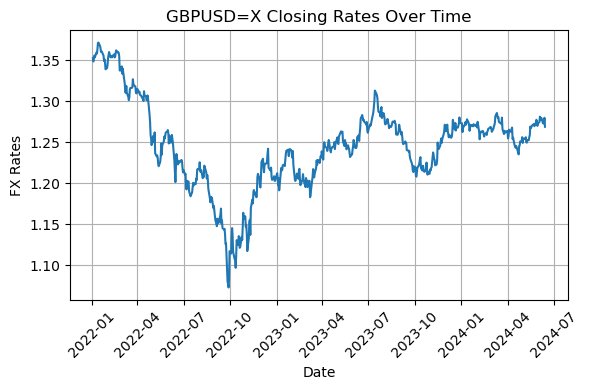

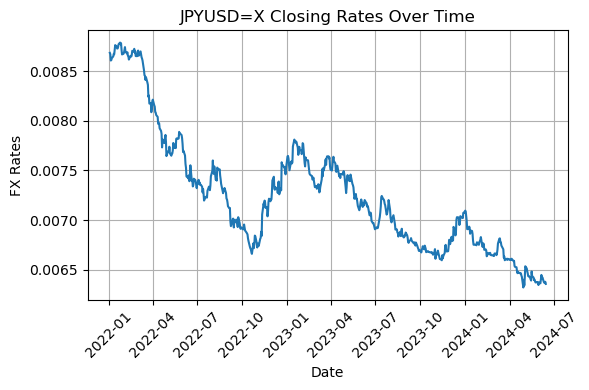

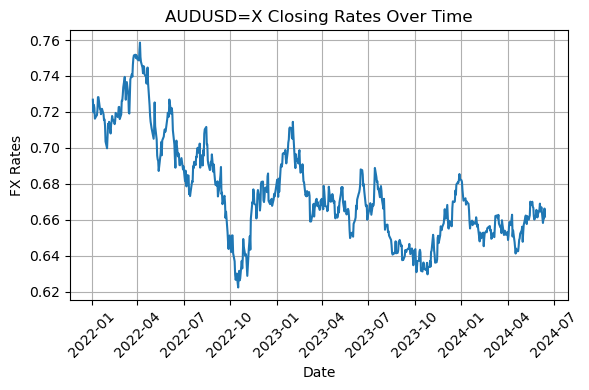

In [ ]:
### Plot FX Data
def plot_forex(df, forex_pairs):
    # Create Loop to Plot Each Individual FX Pair
    for pair in forex_pairs:
        plt.figure(figsize = (6, 4))

        plt.plot(df['Date'], df[pair]) # Need to adjust to spit out multiple graphs for each ticker
        plt.title(pair + ' Closing Rates Over Time')
        plt.xlabel('Date')
        plt.ylabel('FX Rates')

        plt.xticks(rotation = 45)  # Rotate x-axis labels for better readability
        plt.grid(True)
        plt.tight_layout()

    return plt.show()

plot_forex(forex_data, forex_pairs)

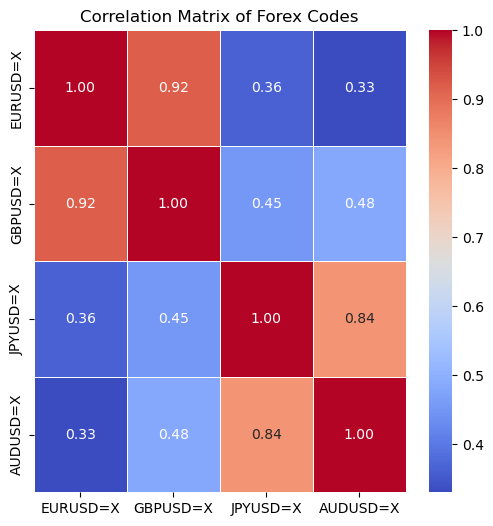

In [ ]:
### Correlation Matrix - Heat Map
def corr_matrix(df):
    df = df.drop(['Date'], axis = 1)
    correlation_matrix = df.corr()
    # Create the day Data heatmap using seaborn
    plt.figure(figsize = (6, 6))
    sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f', linewidths = 0.5)
    plt.title('Correlation Matrix of Forex Codes')
    plt.show()

# Create and display the correlation matrix heatmap
corr_matrix(forex_data)

In [ ]:
### Compute Stacked Correlation
def stacked_correlations(df):
    # Compute the correlation matrix of the DataFrame
    corr_matrix = df.corr()
    # Stack the correlation matrix to convert it into a Series
    stacked_corr = corr_matrix.stack()
    # Filter out correlation values = 1 (self-correlation)
    filtered_corr = stacked_corr[stacked_corr < 1]
    # Sort the correlations in descending order
    sorted_corr = filtered_corr.sort_values(ascending=False)

    return sorted_corr

# Return Stacked Correlation -> Chose the forex pairs that are the most correlated (top of the list)
stacked_corr = stacked_correlations(forex_data)
print(stacked_corr.head(5))

GBPUSD=X  EURUSD=X    0.918666
EURUSD=X  GBPUSD=X    0.918666
AUDUSD=X  JPYUSD=X    0.843037
JPYUSD=X  AUDUSD=X    0.843037
AUDUSD=X  GBPUSD=X    0.483982
dtype: float64


In [ ]:
### Calculate daily returns of Most Correlated Pairs
# Compute stacked correlation and get the most correlated pairs
stacked_corr = stacked_correlations(forex_data)
most_corr_pairs = list(stacked_corr.index[0])
print("Most correlated pairs:", most_corr_pairs)

# Get FX data for the most correlated pairs
most_corr_fx = forex_data[['Date'] + most_corr_pairs]

# Compute the daily returns of the most correlated pairs
most_corr_fx.set_index('Date', inplace=True)
returns = most_corr_fx.pct_change().dropna()

# Reset Headers
returns.reset_index(inplace=True)
# Display the computed daily returns
returns.tail()

Most correlated pairs: ['GBPUSD=X', 'EURUSD=X']


,Date,GBPUSD=X,EURUSD=X
634,2024-06-10,-0.004990,-0.010606
635,2024-06-11,-0.000242,-0.001356
636,2024-06-12,0.001108,-0.002223
637,2024-06-13,0.004376,0.006780
638,2024-06-14,-0.008513,-0.010274


In [41]:
### Compute VAR
# Calculate the 95% Value at Risk (VaR) for each currency pair
# Ex. When EURUSD=X: -0.008645, that means with 95% confidence, the most that the EURUSD rate is expected to 
# lose in one day is approximately 0.8645% of its value.
VaR = returns.quantile(0.05)
print("Value at Risk (95% Confidence level):\n", VaR)

Value at Risk (95% Confidence level):
 Date        2022-02-16 21:36:00
GBPUSD=X              -0.009976
EURUSD=X              -0.008708
Name: 0.05, dtype: object


In [43]:
### Compute Hedge Ratio
# Run linear regression to compute the hedge ratio
rets1 = returns[most_corr_pairs[0]]
rets2 = returns[most_corr_pairs[1]]
# Add a constant to the independent variable
rets1 = sm.add_constant(rets1)
# Fit the regression model
model = sm.OLS(rets2, rets1).fit()
# Extract the hedge ratio
hedge_ratio = model.params[most_corr_pairs[0]]
print("Hedge Ratio:", hedge_ratio)


Hedge Ratio: 0.6656839194353757


In [50]:
### Define and Calculate Position Sizes (Backtesting)
long_pos = 1000  # value of the long position
short_pos = -hedge_ratio * long_pos
print("Long Position Size: ", long_pos)
print("Short Position Size: ", round(short_pos, 4))

# Compute daily returns for the long and short positions
long_rets = rets1
short_rets = -hedge_ratio * long_rets

# Compute the returns of the hedged and unhedged positions
hedged_returns = long_rets + short_rets
unhedged_returns = long_rets

# Compute cumulative returns for the hedged and unhedged positions



Long Position Size:  1000
Short Position Size:  -665.6839
